# 3-parameter interpolation for two-qubit Cartan coordinates

In [1]:
import random
import sys,io
from scipy.spatial import Delaunay
from qctrl_optimize import hamiltonians
from qctrl_optimize import optimize as opt
from qctrl_optimize import gates
from qctrl_optimize import simulate as sim
from qctrl_optimize import interpolate as interp
from qctrl_optimize import plot as plotter
from qctrl import Qctrl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pickle
from itertools import product
qctrl = Qctrl()

Q-CTRL package update available.

Your version is 20.0.2. Latest version is 20.1.0.

Visit ]8;id=832422;https://boulder.q-ctrl.com/changelog\boulder.q-ctrl.com/changelog]8;;\ for the latest product updates.

In [2]:
# Set up parameters for the Interpolater

num_pwc_segments = 5
segment_count = 500
duration = np.pi
sample_times = np.linspace(0, duration, segment_count)
amplitude=1
tik0 = 1e-2
tik0 = tik0 / (amplitude**2 * num_pwc_segments)
seed = 1 # reproducability
random.seed(seed)

def in_weyl(pts):
    return (1 >= pts[:,0]) * (np.minimum(pts[:,0], 1-pts[:,0]) >= pts[:,1]) * (pts[:,1] >= pts[:,2]) * (pts[:,2] >= 0)

# get sets of reference points and testing points
def get_points(granularity):
    npts = int(1+1/granularity)
    points = np.array(list(product(np.linspace(0,1,npts), np.linspace(0,1,npts), np.linspace(0,1,npts))))
    return points
granularity_train = 1/6
granularity_test = 1/12
train_points = get_points(granularity_train)
test_points = get_points(granularity_test)

# function mapping pulse signals to Hamiltonian
def sigs_to_ham(graph, signals):
    hamiltonian, _,_,= hamiltonians.simple_hamiltonian_from_signals(graph, signals)
    return hamiltonian

# function mapping (graph, target, signals) => graph.infidelity
infid_func = opt.get_ham_infid_func(sigs_to_ham)

var_shape = (hamiltonians.SIMPLE_HAM_N_SIG, num_pwc_segments)
# function mapping pulse optimizable variables to signal objects
vals_to_sigs = opt.get_vals_to_sigs_pwc(duration, var_shape, amplitude)

In [3]:
from_scratch = False
num_optimization_rounds = 4

result_dicts = []

In [4]:
if from_scratch:
    interpolater = interp.Interpolater(qctrl, gates.weyl, tik0, interp.neighbor_avg, seed, infid_func, vals_to_sigs)
    
    opt_var_results = None
    for iter in range(num_optimization_rounds):
        if from_scratch:
            if iter > 0:
                train_points, opt_var_results = interp.sort_points_by_tik(train_points, opt_var_results)
            opt_var_results, n_iters = interpolater.train(train_points, first_run=(iter == 0), all_opt_var_results=opt_var_results, max_iter=50)
            infids, simplices = interpolater.test_interpolations(train_points, opt_var_results, test_points)
            result_dict = {'train_points':train_points, 'test_points':test_points, 'infids':infids, 'simplices':simplices, 'n_iters':n_iters, 'opt_var_results':opt_var_results}
            pickle.dump(result_dict, open(f'interpolation_results/cartan/result_dict_full_{iter}.pkl', 'wb'))
            result_dicts.append(result_dict)
else:
    result_dicts += [pickle.load(open(f'interpolation_results/cartan/result_dict_full_{iter}.pkl', 'rb')) for iter in range(num_optimization_rounds)]

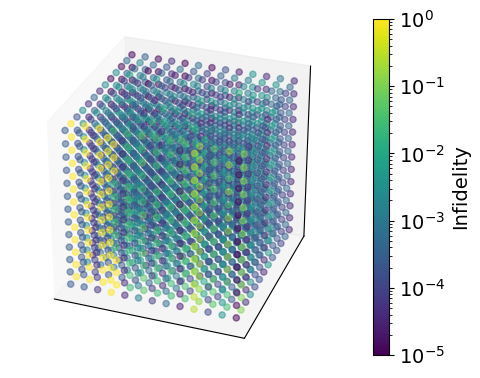

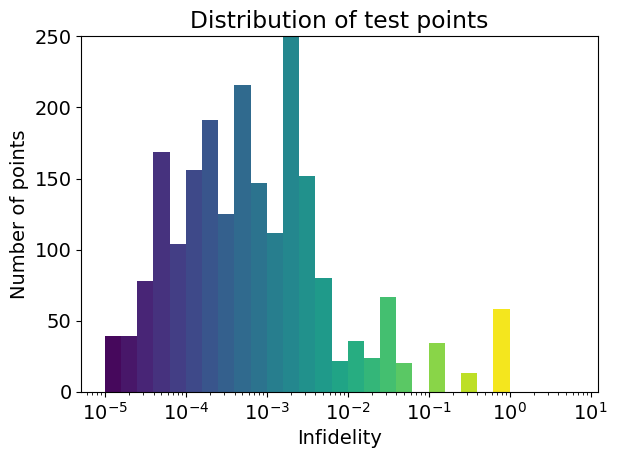

17213
3.27e-02 +- 1.62e-01, 1.00e+00


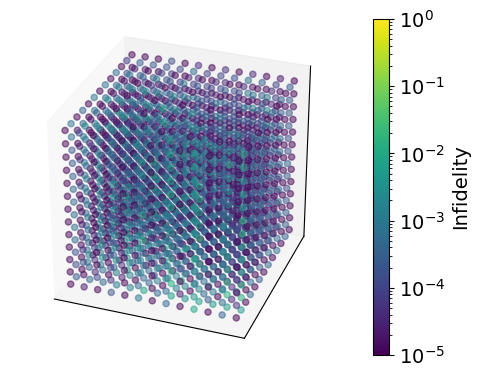

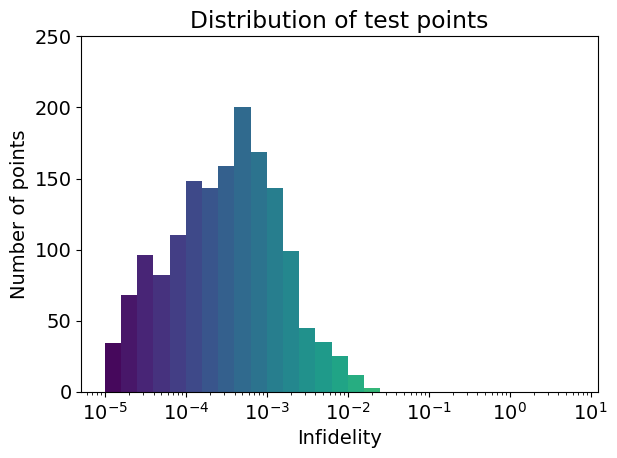

26631
6.62e-04 +- 1.61e-03, 1.95e-02


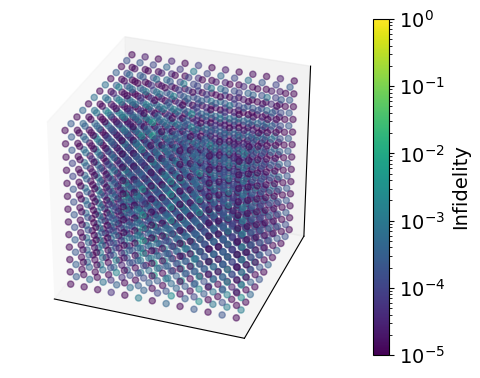

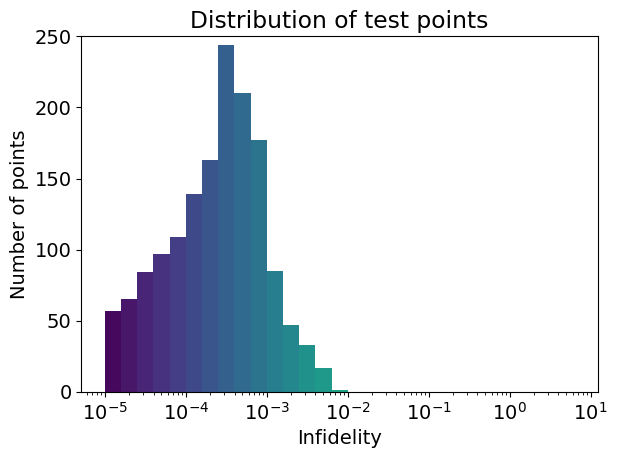

34407
3.55e-04 +- 6.72e-04, 6.54e-03


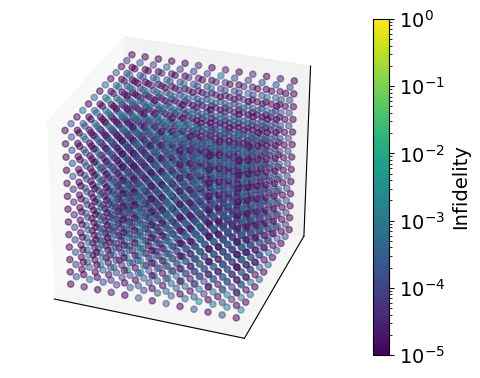

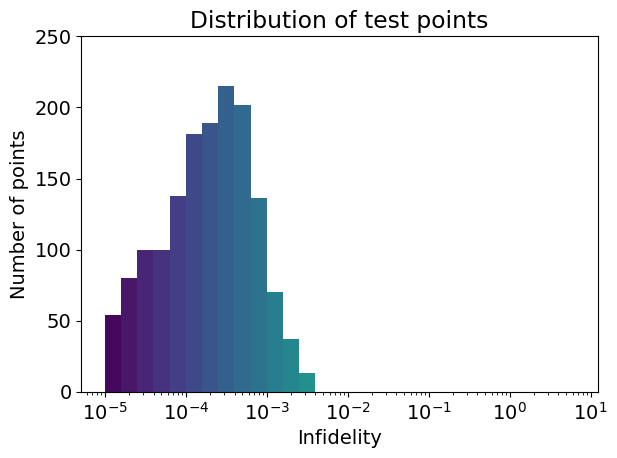

41289
2.54e-04 +- 4.33e-04, 3.91e-03


In [5]:
font = {
    'family' : 'sans',
    'weight' : 'normal',
    'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)

cum_iters = 0
for i,result in enumerate(result_dicts):
    plotter.plot_interpolation(result['test_points'], result['infids'], result['train_points'], result['simplices'], aspect=(1,1,1), hist_ylim=(0,250), draw_simplices=False, savepath=f'interpolation_results/cartan/{i}_')
    cum_iters += np.sum(result['n_iters'])
    print(cum_iters)
    print(f"{np.mean(result['infids']):0.2e} +- {np.std(result['infids']):0.2e}, {np.max(result['infids']):0.2e}")